## AC and A2C: Advanced Actor-Critic (A2C) algorithm

其实就是AC去基线的算法

AC估计$Q(s, a)$的critic模型没有去基线，用target-value产生基线

“换个角度来想这个问题,target是根据next_state估计出来的,value是根据state估计出来的

所以两者的差值可以视为action好坏的衡量,这可以作为actor模型训练的依据”

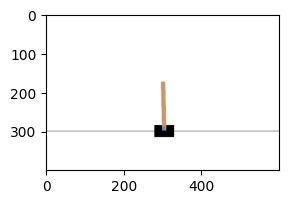

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
        over = True
    
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch
	
# 演员模型：计算动作概率
model_actor = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
	torch.nn.Softmax(dim=1),
)

# 评委模型：计算每个动作价值
model_critic = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)

model_critic_delay = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)

model_critic_delay.load_state_dict(model_critic.state_dict())

model_actor, model_critic

(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
   (5): Softmax(dim=1)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=1, bias=True)
 ))

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
	state = []
	action = []
	reward = []
	next_state = []
	over = []

	s = env.reset()
	o = False
	while not o:
		# 根据环境采样
		prob = model_actor(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
		a = random.choices(range(2), weights=prob, k=1)[0]
		
		ns, r, o = env.step(a)

		state.append(s)
		action.append(a)
		reward.append(r)
		next_state.append(ns)
		over.append(o)
  
		s = ns

		if show:
			display.clear_output(wait=True)
			env.show()
  
	state = torch.FloatTensor(state).reshape(-1, 4)
	action = torch.LongTensor(action).reshape(-1, 1)
	reward = torch.FloatTensor(reward).reshape(-1, 1)
	next_state = torch.FloatTensor(next_state).reshape(-1, 4)
	over = torch.LongTensor(over).reshape(-1, 1)

	return state, action, reward, next_state, over, reward.sum().item()

state, action, reward, next_state, over, reward_sum = play()

reward_sum

C:\Users\fanyu\AppData\Local\Temp\ipykernel_45144\195736856.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor(state).reshape(-1, 4)


-986.0

In [4]:
optimizer_actor = torch.optim.Adam(model_actor.parameters(), lr=4e-3)
optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=4e-2)

def requires_grad(model, value):
  for param in model.parameters():
    param.requires_grad_(value)

In [5]:
# critic 模型训练
def train_critic(state, reward, next_state, over):
  requires_grad(model_actor, False)
  requires_grad(model_critic, True)
  
  # 计算values和targets
  value = model_critic(state)
  
  with torch.no_grad():
    target = model_critic_delay(next_state)
  target = target * 0.99 * (1 - over) + reward
  
  # 时序差分： tdloss
  loss = torch.nn.functional.mse_loss(value, target)
  
  loss.backward()
  optimizer_critic.step()
  optimizer_critic.zero_grad()
  
  # 去基线
  return (target - value).detach() # code change here

value = train_critic(state, reward, next_state, over)
value.shape

torch.Size([15, 1])

In [6]:
# 训练actor
def train_actor(state, action, value):
  requires_grad(model_actor, True)
  requires_grad(model_critic, False)
  
  # 重新计算动作概率
  prob = model_actor(state)
  prob = prob.gather(dim=1, index=action)
  
  # 根据策略梯度算法发的导函数
  # 函数中的Q(state, action), 用critic模型估计
  prob = (prob + 1e-8).log() * value
  loss = -prob.mean()
  
  loss.backward()
  optimizer_actor.step()
  optimizer_actor.zero_grad()
  
  return loss.item()

train_actor(state, action, value)

-41.16533660888672

In [7]:
#训练
def train():
	model_actor.train()
	model_critic.train()

	# 共更新N轮数据
	for epoch in range(1000):
		# 一个epoch玩N步
		steps = 0
		while steps < 200:
			# 玩一局，得到数据
			state, action, reward, next_state, over, _ = play()
			steps += len(state)

			# 训练两个模型
			value = train_critic(state, reward, next_state, over)
			loss = train_actor(state, action, value)
  
		# 复制参数
		for param, param_delay in zip(model_critic.parameters(),
                                model_critic_delay.parameters()):
			value = param_delay.data * 0.7 + param.data * 0.3
			param_delay.data.copy_(value)
  
		if epoch % 100 == 0:
			test_result = sum([play()[-1] for _ in range(20)]) / 20
			print(epoch, loss, test_result)

train()

0 28.257709503173828 -982.3
100 -0.3256535828113556 -3.2
200 -1.7218737602233887 149.75
300 0.21917232871055603 200.0
400 0.02079101651906967 200.0
500 0.0702286809682846 200.0
600 -0.06104029342532158 200.0
700 0.016140108928084373 200.0
800 -1.173439621925354 200.0
900 0.24530361592769623 200.0


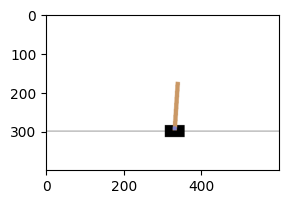

200.0

In [8]:
play(True)[-1]